In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [19]:
# https://iwatobipen.wordpress.com/2020/01/21/make-report-with-rdkit-and-matplotlib-rdkit-memo-chemoinformatics/
# https://iwatobipen.wordpress.com/2017/11/03/draw-high-quality-molecular-image-in-rdkit-rdkit/

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from matplotlib.backends.backend_pgf import PdfPages
import os
from PIL import Image
import io
import matplotlib.image as mpimg
import cairosvg
import shap

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold, KFold
from scipy.stats import pearsonr
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import hp
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.preprocessing import PowerTransformer
from scipy.optimize import minimize, least_squares, brute
from scipy import optimize
from scipy.stats import boxcox
import pickle

In [2]:
sns.set_style("ticks", {'xtick.direction': 'in', 'ytick.direction': 'in'})
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 1.0})

from pylab import *
rc('axes', linewidth=1.0)
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Build a model

In [21]:
# Rdkit 2048 (path length 7)
#df_2 = pd.read_csv('df_fin_2048.csv')
df_2 = pd.read_csv('df_fin_path_2048_2_short.csv')
#df_2 = pd.read_csv('df_fin_path_2048_7_short.csv')


In [20]:
# Morgan 2048 (radius 7)
df_2 = pd.read_csv('df_fin_morgan_2048_6_short.csv')

In [142]:
# PubChem 881
df_2 = pd.read_csv('df_fin_PubChem_short.csv')

In [163]:
# MACCS 166
#df_2 = pd.read_csv('df_fin_MACCS.csv')
df_2 = pd.read_csv('df_fin_MACCS_short.csv')

In [22]:
df_2

,Types of contaminants,pH,MB MWCO (Da),MB contact angle,removal rate (%),1,2,3,4,5,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,2(2butoxyethoxy)ethanol,7.0,150,50.0,81.5900,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,caprolactam,7.0,150,50.0,82.8500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,creatine,7.0,150,50.0,96.6500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,formaldehyde,7.0,150,50.0,3.3500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,isopropanol,7.0,150,50.0,65.2700,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,indomethacin,7.0,200,22.6,97.0719,1,0,0,0,0,...,0,0,1,1,0,1,1,0,1,0
1783,cephalexinhydrate,7.0,200,22.6,95.2613,0,1,0,1,0,...,0,1,0,0,0,1,1,1,0,1
1784,diltiazem,7.0,200,22.6,98.3872,0,0,1,1,0,...,0,0,0,1,1,1,0,1,1,1
1785,erythromycin,7.0,200,22.6,94.7621,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


In [21]:
df_2.drop(labels=['Types of contaminants'], axis=1, inplace=True)

In [22]:
y_data = df_2['removal rate (%)']
x_data = df_2.copy()
x_data.drop(columns=['removal rate (%)'], inplace=True)

In [23]:
y_data_trans = y_data.values.reshape(-1, 1)

(array([ 61.,  70.,  57.,  66.,  46.,  68.,  71., 170., 293., 885.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

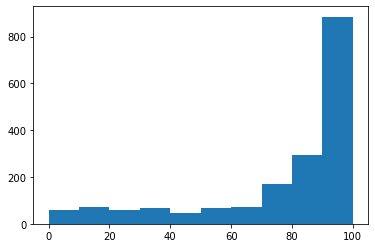

In [24]:
plt.hist(y_data)

In [62]:
y_data.agg(['skew', 'kurtosis']).transpose()

skew       -1.405726
kurtosis    0.765064
Name: removal rate (%), dtype: float64

In [25]:
# le_mem_type = LabelEncoder()
# x_data.iloc[:,0] = le_mem_type.fit_transform(x_data.iloc[:,0])
# le_con_type = LabelEncoder()
# x_data.iloc[:,1] = le_mem_type.fit_transform(x_data.iloc[:,1])

#scaler_mem_type = preprocessing.MinMaxScaler()
#scaler_con_type = preprocessing.MinMaxScaler()
scaler_pH = preprocessing.MinMaxScaler()
scaler_MWCO = preprocessing.MinMaxScaler()
scaler_CA = preprocessing.MinMaxScaler()
#scaler_zeta = preprocessing.MinMaxScaler()
#scaler_kPa = preprocessing.MinMaxScaler()
#scaler_conc = preprocessing.MinMaxScaler()
scaler_removal = preprocessing.MinMaxScaler()

# scaler_mem_type.fit(x_data.loc[:,'Type of MB'].values.reshape(-1,1))
# temp_0 = scaler_mem_type.transform(x_data.loc[:,'Type of MB'].values.reshape(-1,1))
# scaler_con_type.fit(x_data.loc[:,'Types of contaminants'].values.reshape(-1,1))
# temp_1 = scaler_con_type.transform(x_data.loc[:,'Types of contaminants'].values.reshape(-1,1))
scaler_pH.fit(x_data.loc[:,'pH'].values.reshape(-1,1))
temp_2 = scaler_pH.transform(x_data.loc[:,'pH'].values.reshape(-1,1))
scaler_MWCO.fit(x_data.loc[:,'MB MWCO (Da)'].values.reshape(-1,1))
temp_3 = scaler_MWCO.transform(x_data.loc[:,'MB MWCO (Da)'].values.reshape(-1,1))
scaler_CA.fit(x_data.loc[:,'MB contact angle'].values.reshape(-1,1))
temp_4 = scaler_CA.transform(x_data.loc[:,'MB contact angle'].values.reshape(-1,1))
# scaler_zeta.fit(x_data.loc[:,'MB zeta potential'].values.reshape(-1,1))
# temp_5 = scaler_zeta.transform(x_data.loc[:,'MB zeta potential'].values.reshape(-1,1))
# scaler_kPa.fit(x_data.loc[:,'Pressure (kPa)'].values.reshape(-1,1))
# temp_6 = scaler_kPa.transform(x_data.loc[:,'Pressure (kPa)'].values.reshape(-1,1))
# scaler_conc.fit(x_data.loc[:,'Initial concentration of compound (mg/L)'].values.reshape(-1,1))
# temp_7 = scaler_conc.transform(x_data.loc[:,'Initial concentration of compound (mg/L)'].values.reshape(-1,1))
scaler_removal.fit(y_data_trans)
temp_8 = scaler_removal.transform(y_data_trans)

x_data_scaled = pd.DataFrame()
y_data_scaled = pd.DataFrame()

# x_data_scaled['Type of MB'] = temp_0.reshape(1,-1).tolist()[0]
# x_data_scaled['Types of contaminants'] = temp_1.reshape(1,-1).tolist()[0]
x_data_scaled['pH'] = temp_2.reshape(1,-1).tolist()[0]
x_data_scaled['MB MWCO (Da)'] = temp_3.reshape(1,-1).tolist()[0]
x_data_scaled['MB contact angle'] = temp_4.reshape(1,-1).tolist()[0]
#x_data_scaled['MB zeta potential'] = temp_5.reshape(1,-1).tolist()[0]
#x_data_scaled['Pressure (kPa)'] = temp_6.reshape(1,-1).tolist()[0]
#x_data_scaled['Initial concentration of compound (mg/L)'] = temp_7.reshape(1,-1).tolist()[0]
y_data_scaled = temp_8.reshape(1,-1).tolist()[0]

In [26]:
x_data.reset_index(drop=True, inplace=True)

In [27]:
x_data_scaled = pd.concat([x_data_scaled, x_data.iloc[:, 3:]], axis=1)

In [28]:
x_data_scaled

,pH,MB MWCO (Da),MB contact angle,1,2,3,4,5,6,7,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0.534884,0.215190,0.542056,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.534884,0.215190,0.542056,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.534884,0.215190,0.542056,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.534884,0.215190,0.542056,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.534884,0.215190,0.542056,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,0.534884,0.341772,0.115265,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1783,0.534884,0.341772,0.115265,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1784,0.534884,0.341772,0.115265,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1785,0.534884,0.341772,0.115265,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# stratified splits

mini = np.amin(y_data_scaled)
maxi = np.amax(y_data_scaled)
bins = np.linspace(start=mini, stop=maxi, num=20)
y_binned = np.digitize(y_data_scaled, bins, right=True)
x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data_scaled, test_size=0.2, random_state=3, stratify=y_binned)

[0]	validation_0-rmse:0.36174	validation_1-rmse:0.360185
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[3]	validation_0-rmse:0.30731	validation_1-rmse:0.306165
[6]	validation_0-rmse:0.271296	validation_1-rmse:0.271862
[9]	validation_0-rmse:0.24812	validation_1-rmse:0.249875
[12]	validation_0-rmse:0.232879	validation_1-rmse:0.236016
[15]	validation_0-rmse:0.22256	validation_1-rmse:0.226533
[18]	validation_0-rmse:0.215232	validation_1-rmse:0.219781
[21]	validation_0-rmse:0.208972	validation_1-rmse:0.215321
[24]	validation_0-rmse:0.20475	validation_1-rmse:0.211581
[27]	validation_0-rmse:0.200037	validation_1-rmse:0.208082
[30]	validation_0-rmse:0.197351	validation_1-rmse:0.206614
[33]	validation_0-rmse:0.193891	validation_1-rmse:0.203958
[36]	validation_0-rmse:0.19166	validation_1-rmse:0.202498
[39]	validation_0-rmse:0.189294	validation_1-rmse:0.199903
[42]	validation_0-rmse:0.

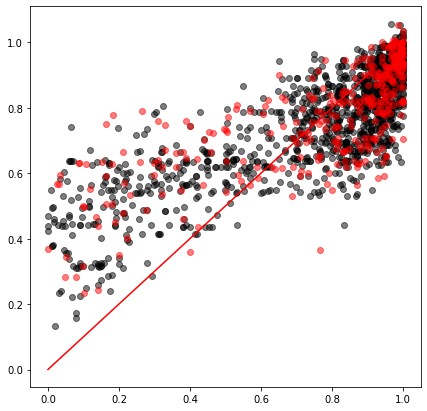

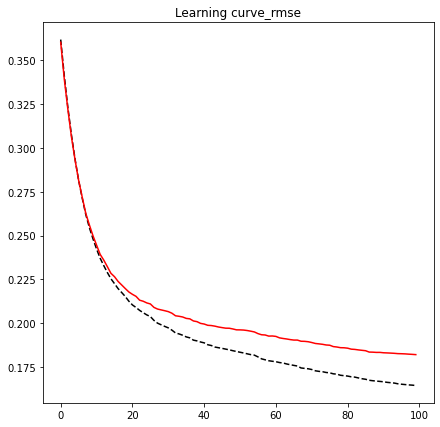

In [30]:
#x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data_scaled, test_size=0.2, random_state=3)

model_CA_1 = XGBRegressor(objective = 'reg:squarederror')
#model_CA_1 = XGBClassifier()
evaluation = [(x_train, y_train), (x_test, y_test)]
model_CA_1.fit(x_train, y_train, eval_set = evaluation, eval_metric = "rmse", early_stopping_rounds=10, verbose=3)
# model_CA_1.fit(x_train, y_train)
pred_train = model_CA_1.predict(x_train)
pred_test = model_CA_1.predict(x_test)

print(r2_score(y_train, pred_train))
print(r2_score(y_test, pred_test))

# print(accuracy_score(y_test, pred_CA_1))
# print(precision_score(y_test, pred_CA_1, average='macro'))
# print(recall_score(y_test, pred_CA_1, average='macro'))
# print(classification_report(y_test, pred_CA_1))

plt.figure(figsize=(7,7))
plt.scatter(y_train, pred_train, c='k', alpha=0.5)
plt.scatter(y_test, pred_test, c='r', alpha=0.5)
plt.plot(np.arange(0, 1.0, 0.1), np.arange(0, 1.0, 0.1), 'r-')
plt.show()

results = model_CA_1.evals_result()
plt.figure(figsize=(7,7))
plt.title('Learning curve_rmse')
plt.plot(results['validation_0']['rmse'], 'k--') #train
plt.plot(results['validation_1']['rmse'], 'r-') #test
plt.show()

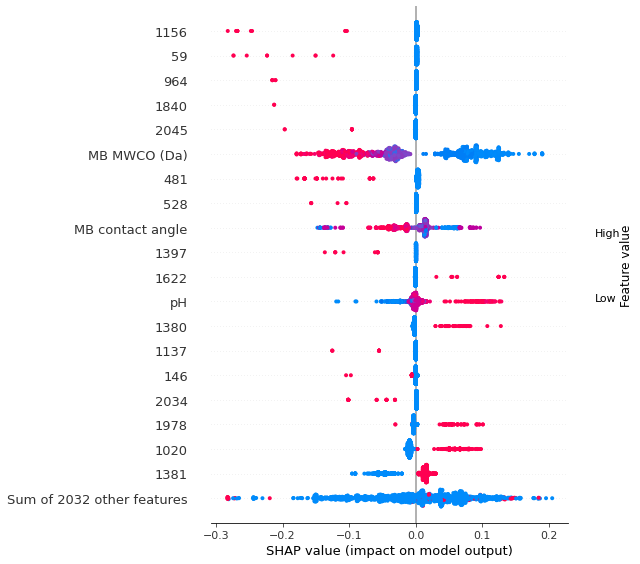

In [31]:
explainer = shap.Explainer(model_CA_1)
shap_values = explainer(x_train)
shap.plots.beeswarm(shap_values, max_display=20, order=shap_values.abs.max(0))

In [14]:
# XGBRegressor with Bayesian hyperparameter tuning
#x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data_scaled, test_size=0.2, random_state=3)

space={'max_depth': hp.choice('max_depth', np.arange(3, 50, 1)),
        'gamma': hp.choice('gamma', np.arange(0, 20, 1)),
        'reg_alpha' : hp.quniform('reg_alpha', 0.1, 10, 0.1),
        'reg_lambda' : hp.quniform('reg_lambda', 0.1, 10, 0.1),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.1),
        'min_child_weight' : hp.choice('min_child_weight', np.arange(0, 10, 1)),
        'n_estimators': hp.quniform('n_estimators', 200, 2000, 100),
        'learning_rate': hp.quniform('learning_rate', 0, 0.3, 0.002),
        'subsample': hp.quniform('subsample', 0.2, 1, 0.1),
        'colsample_bylevel': hp.quniform('colsample_bylevel', 0.2, 1, 0.1),
        'colsample_bynode': hp.quniform('colsample_bynode', 0.2, 1, 0.1),
      }

kf = KFold(n_splits=6, shuffle=True, random_state=3)

def objective(space, cv=kf, X=x_train, y=y_train):
    clf = XGBRegressor(objective = 'reg:squarederror', n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                       reg_alpha = int(space['reg_alpha']), reg_lambda = int(space['reg_lambda']), min_child_weight=space['min_child_weight'],
                       colsample_bytree=space['colsample_bytree'], learning_rate=space['learning_rate'], subsample=space['subsample'],
                       colsample_bylevel=space['colsample_bylevel'], colsample_bynode=space['colsample_bynode'], random_state = 3)
    
    score = -cross_val_score(clf, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    return score

trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300, trials=trials, rstate=np.random.RandomState(3))
print(best_hyperparams)

100%|██████████████████████████████████████████| 300/300 [6:34:48<00:00, 78.96s/trial, best loss: 0.022877036474348925]
{'colsample_bylevel': 0.4, 'colsample_bynode': 0.5, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.098, 'max_depth': 38, 'min_child_weight': 9, 'n_estimators': 1000.0, 'reg_alpha': 0.9, 'reg_lambda': 2.0, 'subsample': 1.0}


In [15]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_path_2048_2_short.txt', data, fmt='%s')

In [36]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_path_2048_7_short.txt', data, fmt='%s')

In [47]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_rdkit_2048.txt', data, fmt='%s')

In [79]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_rdkit_2048_short_2.txt', data, fmt='%s')

In [14]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_morgan_2048_6.txt', data, fmt='%s')

In [58]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_morgan_2048_6_short.txt', data, fmt='%s')

In [15]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_morgan_2048_7_short.txt', data, fmt='%s')

In [15]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_morgan_2048_2_short.txt', data, fmt='%s')

In [15]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_pubchem_881.txt', data, fmt='%s')

In [14]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_pubchem_881_short.txt', data, fmt='%s')

In [43]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_maccs_166.txt', data, fmt='%s')

In [21]:
data = list(best_hyperparams.items())
np.savetxt('best_hyperparams_maccs_166_short.txt', data, fmt='%s')

In [32]:
best_hyperparams = np.loadtxt("best_hyperparams_morgan_2048_6_short.txt", dtype=str)
best_hyperparams = dict(best_hyperparams)
for k, v in best_hyperparams.items():
    best_hyperparams[k] = float(v)

In [33]:
best_hyperparams

{'colsample_bylevel': 0.7000000000000001,
 'colsample_bynode': 0.6000000000000001,
 'colsample_bytree': 1.0,
 'gamma': 0.0,
 'learning_rate': 0.056,
 'max_depth': 19.0,
 'min_child_weight': 7.0,
 'n_estimators': 900.0,
 'reg_alpha': 0.1,
 'reg_lambda': 2.9000000000000004,
 'subsample': 1.0}

In [34]:
# XGBRegressor with Bayesian best parameters
model_B_best = XGBRegressor(objective = 'reg:squarederror', n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
                             gamma = best_hyperparams['gamma'], reg_alpha = int(best_hyperparams['reg_alpha']), reg_lambda = int(best_hyperparams['reg_lambda']), min_child_weight=best_hyperparams['min_child_weight'],
                             colsample_bytree=best_hyperparams['colsample_bytree'], learning_rate=best_hyperparams['learning_rate'], 
                             subsample=best_hyperparams['subsample'], colsample_bylevel=best_hyperparams['colsample_bylevel'], 
                             colsample_bynode=best_hyperparams['colsample_bynode'], random_state = 3)

evaluation = [(x_train, y_train), (x_test, y_test)]
model_B_best.fit(x_train, y_train, eval_set = evaluation, eval_metric = "rmse", verbose=3)#, early_stopping_rounds=10)
y_pred_train_best = model_B_best.predict(x_train)
y_pred_test_best = model_B_best.predict(x_test)
print(r2_score(y_train, y_pred_train_best))
print(r2_score(y_test, y_pred_test_best))
results = model_B_best.evals_result()


# # Cross validation
# model_B_best_cv = XGBRegressor(objective = 'reg:squarederror', n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
#                              gamma = best_hyperparams['gamma'], reg_alpha = int(best_hyperparams['reg_alpha']), reg_lambda = int(best_hyperparams['reg_lambda']), min_child_weight=best_hyperparams['min_child_weight'],
#                              colsample_bytree=best_hyperparams['colsample_bytree'], learning_rate=best_hyperparams['learning_rate'], 
#                              subsample=best_hyperparams['subsample'], colsample_bylevel=best_hyperparams['colsample_bylevel'], 
#                              colsample_bynode=best_hyperparams['colsample_bynode'], random_state = 3)

# n_repeats = 6
# for i in range(n_repeats):
#     cv = RepeatedKFold(n_splits = 6, n_repeats = 1, random_state = i) # n_splits = 3 or 6?
#     cv_predictions = cross_val_predict(model_B_best_cv, x_data_scaled, y_data_scaled, cv=cv, n_jobs=-1)
    
#     if i == 0:
#         old = cv_predictions
#     else:
#         old = (np.array(old) + np.array(cv_predictions))/2

# print("R2 is ", r2_score(y_data_scaled, old))
# # how to add plot_importance with a CV model?

[0]	validation_0-rmse:0.369356	validation_1-rmse:0.369653
[3]	validation_0-rmse:0.324954	validation_1-rmse:0.327044
[6]	validation_0-rmse:0.28755	validation_1-rmse:0.291809
[9]	validation_0-rmse:0.25765	validation_1-rmse:0.264463
[12]	validation_0-rmse:0.231975	validation_1-rmse:0.241391
[15]	validation_0-rmse:0.211239	validation_1-rmse:0.223297
[18]	validation_0-rmse:0.193922	validation_1-rmse:0.208421
[21]	validation_0-rmse:0.179115	validation_1-rmse:0.197026
[24]	validation_0-rmse:0.166162	validation_1-rmse:0.185963
[27]	validation_0-rmse:0.155581	validation_1-rmse:0.178314
[30]	validation_0-rmse:0.147312	validation_1-rmse:0.172454
[33]	validation_0-rmse:0.13964	validation_1-rmse:0.166817
[36]	validation_0-rmse:0.132898	validation_1-rmse:0.162387
[39]	validation_0-rmse:0.127109	validation_1-rmse:0.158787
[42]	validation_0-rmse:0.122204	validation_1-rmse:0.155359
[45]	validation_0-rmse:0.117789	validation_1-rmse:0.152234
[48]	validation_0-rmse:0.114275	validation_1-rmse:0.15
[51]	val

[414]	validation_0-rmse:0.071124	validation_1-rmse:0.126598
[417]	validation_0-rmse:0.071073	validation_1-rmse:0.126575
[420]	validation_0-rmse:0.071029	validation_1-rmse:0.126568
[423]	validation_0-rmse:0.070961	validation_1-rmse:0.126561
[426]	validation_0-rmse:0.070911	validation_1-rmse:0.126549
[429]	validation_0-rmse:0.070855	validation_1-rmse:0.12652
[432]	validation_0-rmse:0.070777	validation_1-rmse:0.126523
[435]	validation_0-rmse:0.07071	validation_1-rmse:0.126544
[438]	validation_0-rmse:0.07067	validation_1-rmse:0.126535
[441]	validation_0-rmse:0.07061	validation_1-rmse:0.126572
[444]	validation_0-rmse:0.070567	validation_1-rmse:0.126582
[447]	validation_0-rmse:0.070531	validation_1-rmse:0.126578
[450]	validation_0-rmse:0.070493	validation_1-rmse:0.126558
[453]	validation_0-rmse:0.070446	validation_1-rmse:0.126583
[456]	validation_0-rmse:0.070399	validation_1-rmse:0.126511
[459]	validation_0-rmse:0.070371	validation_1-rmse:0.126467
[462]	validation_0-rmse:0.070335	validation_

[828]	validation_0-rmse:0.067689	validation_1-rmse:0.125424
[831]	validation_0-rmse:0.067681	validation_1-rmse:0.125419
[834]	validation_0-rmse:0.067675	validation_1-rmse:0.125409
[837]	validation_0-rmse:0.067667	validation_1-rmse:0.125407
[840]	validation_0-rmse:0.067657	validation_1-rmse:0.125397
[843]	validation_0-rmse:0.06765	validation_1-rmse:0.125394
[846]	validation_0-rmse:0.067643	validation_1-rmse:0.125379
[849]	validation_0-rmse:0.067633	validation_1-rmse:0.125379
[852]	validation_0-rmse:0.067624	validation_1-rmse:0.12537
[855]	validation_0-rmse:0.067617	validation_1-rmse:0.125369
[858]	validation_0-rmse:0.06761	validation_1-rmse:0.125364
[861]	validation_0-rmse:0.0676	validation_1-rmse:0.125346
[864]	validation_0-rmse:0.06759	validation_1-rmse:0.125347
[867]	validation_0-rmse:0.067584	validation_1-rmse:0.125346
[870]	validation_0-rmse:0.067575	validation_1-rmse:0.125347
[873]	validation_0-rmse:0.067567	validation_1-rmse:0.125349
[876]	validation_0-rmse:0.067555	validation_1-

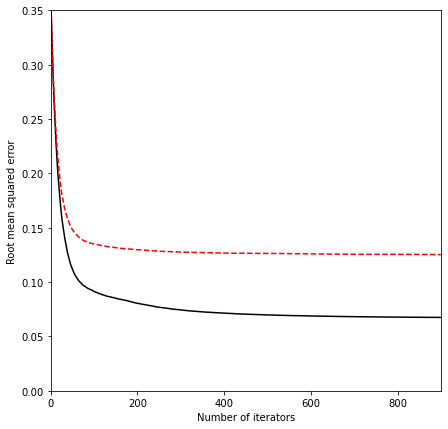

savefig() got unexpected keyword argument "bbox_i6nches" which is no longer supported as of 3.3 and will become an error two minor releases later


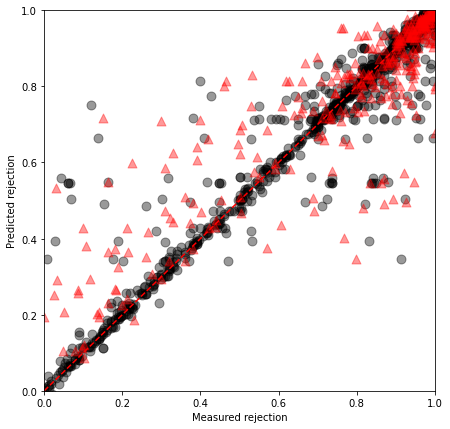

NameError: name 'old' is not defined

<Figure size 504x504 with 0 Axes>

In [36]:
fig = plt.figure(figsize=(7,7))
#plt.title('Learning curve_rmse')
plt.plot(results['validation_0']['rmse'], 'k-') #train
plt.plot(results['validation_1']['rmse'], 'r--') #test
plt.xlabel('Number of iterators')
plt.ylabel('Root mean squared error')
plt.xlim(0, 900)
plt.ylim(0, 0.35)
plt.xticks(np.arange(0,901,200))
plt.show()
fig.savefig("fig_0_morgan_6_short.pdf", bbox_i6nches='tight', transparent=True)

fig = plt.figure(figsize=(7,7))
plt.scatter(y_train, y_pred_train_best, c='k', alpha=0.4, s=80, edgecolors=None)
plt.scatter(y_test, y_pred_test_best, c='r', marker='^', alpha=0.4, s=80, edgecolors=None)
plt.plot(np.arange(0, 1.0, 0.1), np.arange(0, 1.0, 0.1), 'r--')
plt.xlabel('Measured rejection')
plt.ylabel('Predicted rejection')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
fig.savefig("fig_1_morgan_6_short.pdf", bbox_inches='tight', transparent=True)

fig = plt.figure(figsize=(7,7))        
plt.scatter(y_data_scaled, old, c='k', alpha=0.4, s=80, edgecolors=None)
plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), 'r--')
#plt.plot([y_data_scaled.min(), y_data_scaled.max()], [y_data_scaled.min(), y_data_scaled.max()], 'k--', lw=2)
plt.xlabel('Measured rejection')
plt.ylabel('Predicted rejection')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
fig.savefig("fig_2_morgan_6_short.pdf", bbox_inches='tight', transparent=True)

# fig = plt.figure(figsize=(7,7))
# plt.scatter(y_pred_test_best, y_test - y_pred_test_best)
# plt.show()

In [ ]:
# save the model
filename = 'Model_RDkit_2048.sav'
pickle.dump(model_B_best, open(filename, 'wb'))

In [81]:
# save the model
filename = 'Model_RDkit_2048_short_2.sav'
pickle.dump(model_B_best, open(filename, 'wb'))

In [16]:
# save the model
filename = 'Model_Morgan_2048_6.sav'
pickle.dump(model_B_best, open(filename, 'wb'))

In [60]:
# save the model
filename = 'Model_Morgan_2048_6_morgan.sav'
pickle.dump(model_B_best, open(filename, 'wb'))

In [16]:
# save the model
filename = 'Model_PubChem.sav'
pickle.dump(model_B_best, open(filename, 'wb'))

In [16]:
# save the model
filename = 'Model_PubChem_short.sav'
pickle.dump(model_B_best, open(filename, 'wb'))

In [49]:
# save the model
filename = 'Model_MACCS.sav'
pickle.dump(model_B_best, open(filename, 'wb'))

In [52]:
# save the model
filename = 'Model_MACCS_short.sav'
pickle.dump(model_B_best, open(filename, 'wb'))

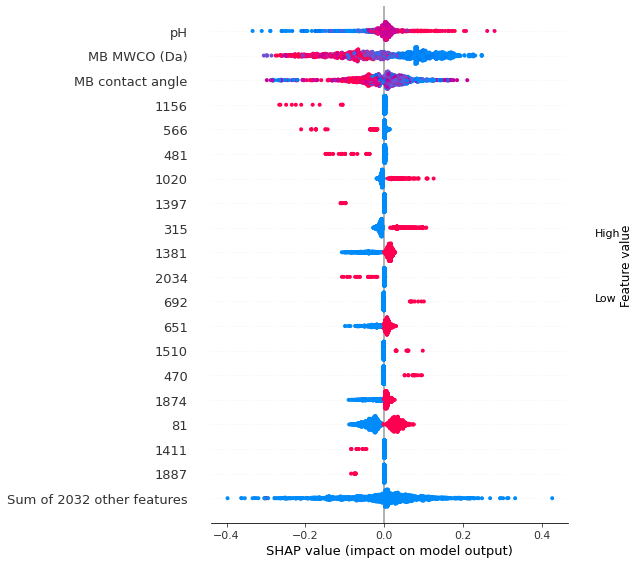

In [35]:
explainer = shap.Explainer(model_B_best)
shap_values = explainer(x_train)
shap.plots.beeswarm(shap_values, max_display=20, order=shap_values.abs.max(0), show=False)#, color=plt.get_cmap("cool"))
#shap.summary_plot(shap_values, x_train)
#plt.savefig("shap_morgan_6_short.pdf", format='pdf', dpi=1000, bbox_inches='tight')
#plt.savefig("shap_morgan.png", format='png', dpi=1000, bbox_inches='tight')

In [49]:
shap.initjs()

In [76]:
shap_values_2 = explainer.shap_values(x_train)
shap.force_plot(explainer.expected_value, shap_values_2[0:5,:], x_train.iloc[0:5,:])

Exception: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 0.041591, while the model output was 0.320452. If this difference is acceptable you can set check_additivity=False to disable this check.

meta NOT subset; don't know how to subset; dropped


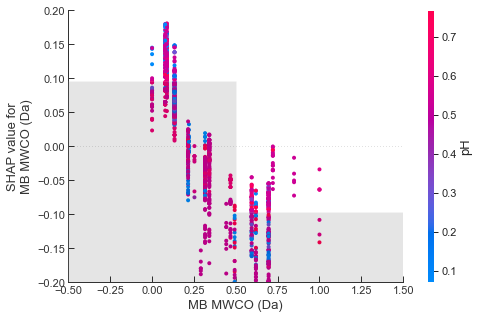

In [21]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html
shap.plots.scatter(shap_values[:,"MB MWCO (Da)"], color=shap_values[:,"pH"], xmin=0, xmax=1.25, ymin=-0.2, ymax=0.2, show=False) #cmap=plt.get_cmap("cool")
plt.savefig("shap_dependence_morgan_2_short.pdf", format='pdf', dpi=1000, bbox_inches='tight')

In [180]:
np.sum(shap_values.abs.max(0).values[3:23])/20

0.0038596674799919128

In [15]:
#https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
# load the model
loaded_model = pickle.load(open('Model_RDkit_2048_short_2.sav', 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.6953144634628119
